<a href="https://colab.research.google.com/github/kalinalinkalina/filmapping/blob/main/read_listings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set up access to files via Google Drive

from google.colab import drive
drive.mount('/content/gdrive/')

import os
if not os.path.exists("/content/gdrive/My Drive/AVL/Rini/"):
    print("ERROR: path does not exist")
os.chdir("/content/gdrive/My Drive/AVL/Rini/")

Mounted at /content/gdrive/


In [ ]:
# Switch beween debug mode or batch mode
debug = True

In [ ]:
# Install tesseract and related tools
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract
!pip install hocr-tools
!pip install Levenshtein
!apt install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,664 kB/s)
Selecting previously unselect

In [ ]:
# Imports

import sys
import os
import math
from io import StringIO, BytesIO
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract 
from pytesseract import Output
import re
import csv
import numpy as np
import imageio
from scipy.ndimage import gaussian_filter, gaussian_filter1d, laplace
import cv2
import skimage
from skimage import exposure
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from lxml import etree as et
import Levenshtein as lev
import regex
import imutils
import glob
from google.colab.patches import cv2_imshow
from pdf2image import convert_from_path
from scipy import stats

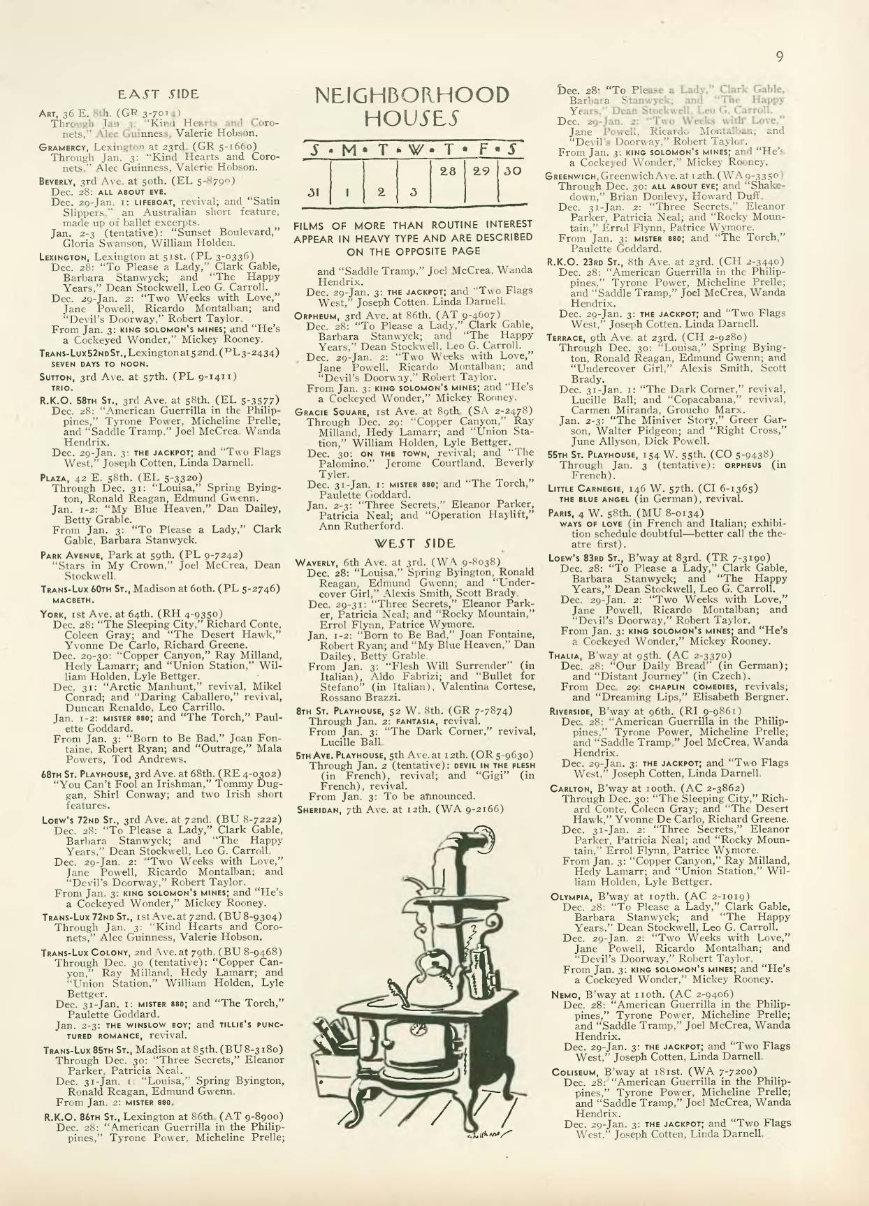

In [ ]:
# Load page

def load_page(path):

  # New Yorker
  if path.endswith(".png") or path.endswith(".jpg"):
    is_New_Yorker = True
    img = cv2.imread(path)

  # Jerusalem Post
  elif path.endswith(".pdf"):
    is_New_Yorker = False
    img = convert_from_path(path, dpi=300)[0]
    w, h = img.size
    # Crop image so that it's just the paper
    img = img.crop([0,80,w,h-100])
    img = np.asarray(img)

  # TXT file assuming base64 format (New Yorker raw images)
  elif path.endswith(".txt"):

    import base64
    import io
    """
    txt = open(path, 'rb').read()
    base64_decoded = base64.b64decode(txt)
    jpg_path = path[:-4] + ".jpg"
    with open(jpg_path, 'wb') as f:
      f.write(base64_decoded)
    img = cv2.imread(jpg_path)
    print(jpg_path)
    """
    txt = open(path, 'rb').read()
    img_PIL = Image.open(BytesIO(base64.b64decode(txt)))
    img = np.asarray(img_PIL)


  else:
    print("ERROR: Unsupported file extension for " + path + ". Must be PNG (New Yorker) or PDF (Jerusalem Post).")
    sys.exit()

  return img, is_New_Yorker



img = None
img_PIL = None

if debug:
  path = "./newspapers/NewYorker/1950/19501230b.png"
  #path = "./newspapers/NewYorker/1945-09-15.png"
  #path = "./newspapers/JerusalemPost/1950-04-23_focus.pdf"
  #path = "./newspapers/NewYorker/test_blob.jpg"
  #path = "./newspapers/NewYorker/19700110a_base64.txt"     #1100x1600 - 90.1% copyleaks
  #path = "./newspapers/NewYorker/19700110a_pczoomed.png" #1700x2400 43 rows, 95.4% confidence, bad titles - 95% copyleaks
  #path = "./newspapers/NewYorker/19700110a_maczoomed.png" #1200x1700 43 rows, 94.9% confidence, bad titles - 89.7% copyleaks
  #path = "./newspapers/NewYorker/19700110b_mac.png"
  img, is_New_Yorker = load_page(path)
  # Display image (need to flip OpenCV's BGR to RGB for display)
  img_PIL = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

res_x, res_y = img_PIL.size[0], img_PIL.size[1]
img_PIL

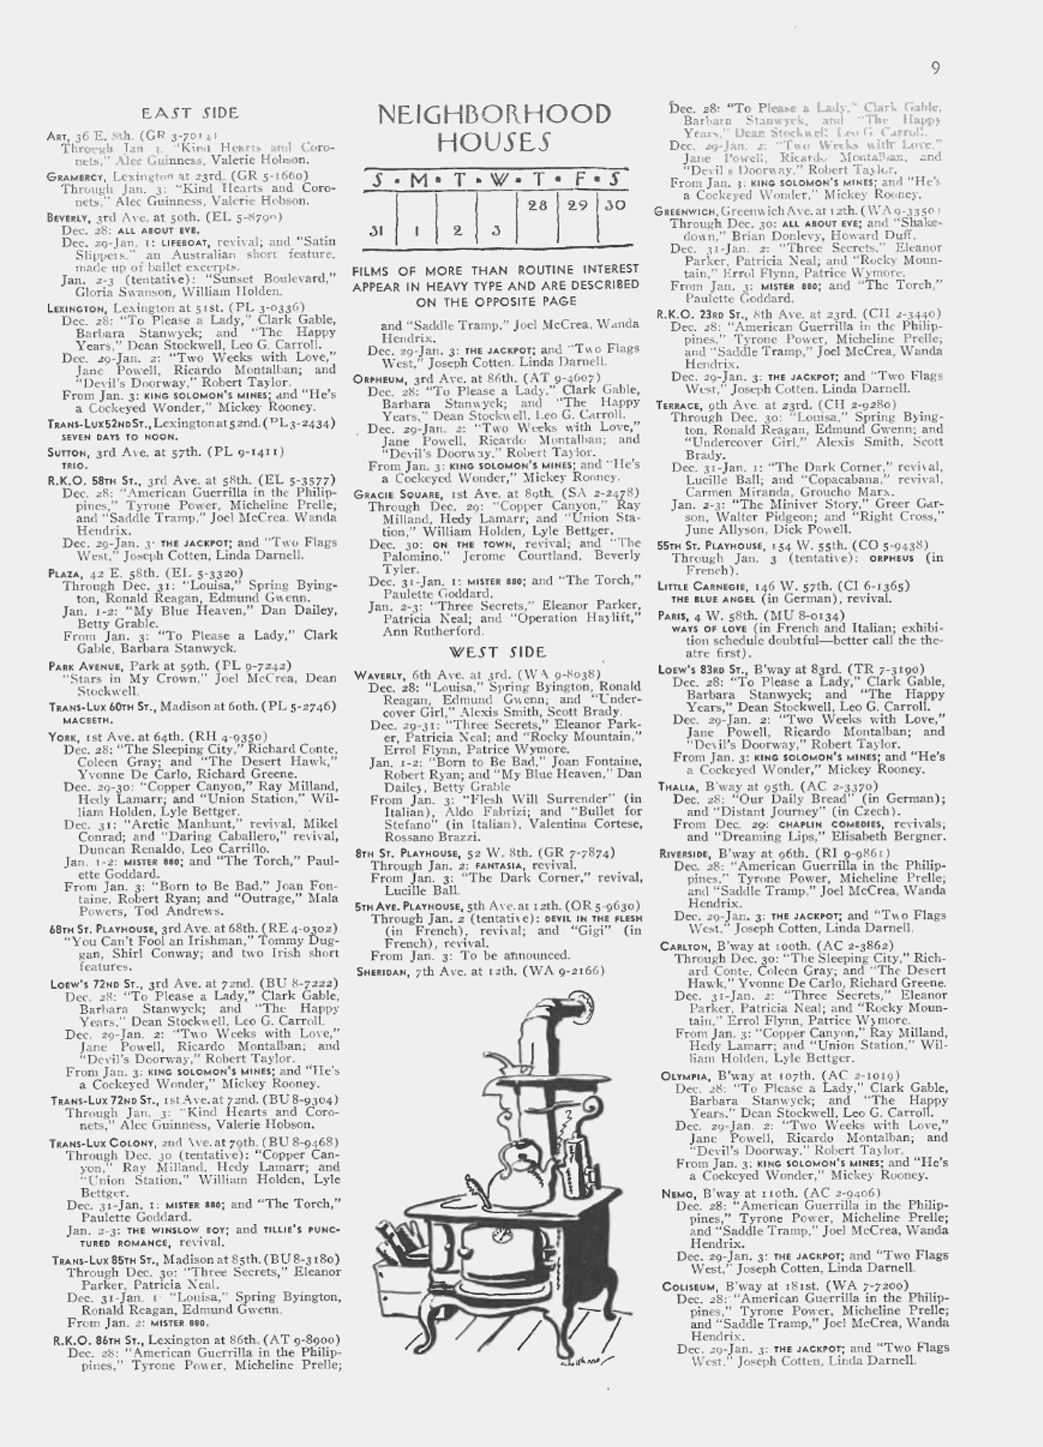

In [ ]:
#Filter image

def increase_contrast(im):
  lab= cv2.cvtColor(np.array(im), cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)
  limg = cv2.merge((cl,a,b))
  final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
  return final

def filter(im):
  """ Denoise, then increase contrast"""

  #img_denoised = cv2.bilateralFilter(im,20,40,50)
  #img_contrasted = increase_contrast(img_denoised)

  # Find the most common pixel value in the image. Use that to threshold text/background. Also use it as background.
  threshold, _ = stats.mode(im, axis=None)

  # Convert image to grayscale
  img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  # Create a text mask by binerizing the image, then eroding, and multiplying the result by the original image.
  _, img_binarized = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
  kernel = np.ones((2,2), np.uint8) 
  img_dilated = cv2.erode(img_binarized, kernel, iterations=1) 
  mask = np.array((255 - img_dilated)/255, np.uint8)
  img_combo = cv2.bitwise_and(img_gray,img_gray,mask = mask)
  img_combo[mask == 0] = threshold

  # Check the image resolution. If the y resolution is less than 1850, increase
  if(res_y<1850):
    img_combo = cv2.resize(img_combo, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
  
  img_filtered = Image.fromarray(cv2.cvtColor(np.array(img_combo), cv2.COLOR_BGR2RGB))

  return img_filtered

  """img_median = cv2.medianBlur(im, 3)

  img_denoised = cv2.bilateralFilter(img,20,40,50) # diameter, sigma_color, sigma_space
  #img_denoised = cv2.bilateralFilter(img,20,200,300) # diameter, sigma_color, sigma_space
  img_contrasted = increase_contrast(img_denoised)
  #img_gray = cv2.cvtColor(img_contrasted, cv2.COLOR_BGR2GRAY)
  #_, img_binarized = cv2.threshold(img_gray, 160, 255, cv2.THRESH_BINARY)


  result = img_median #average(img_median, img_contrasted)
  #edges = cv2.Laplacian(img_gray, cv2.CV_8U)   #64_F
  #edges = 255 - edges

  img_filtered = Image.fromarray(cv2.cvtColor(np.array(result), cv2.COLOR_BGR2RGB))
  return img_filtered"""


img_filtered = None
if debug:
  img_filtered = filter(img)

img_filtered

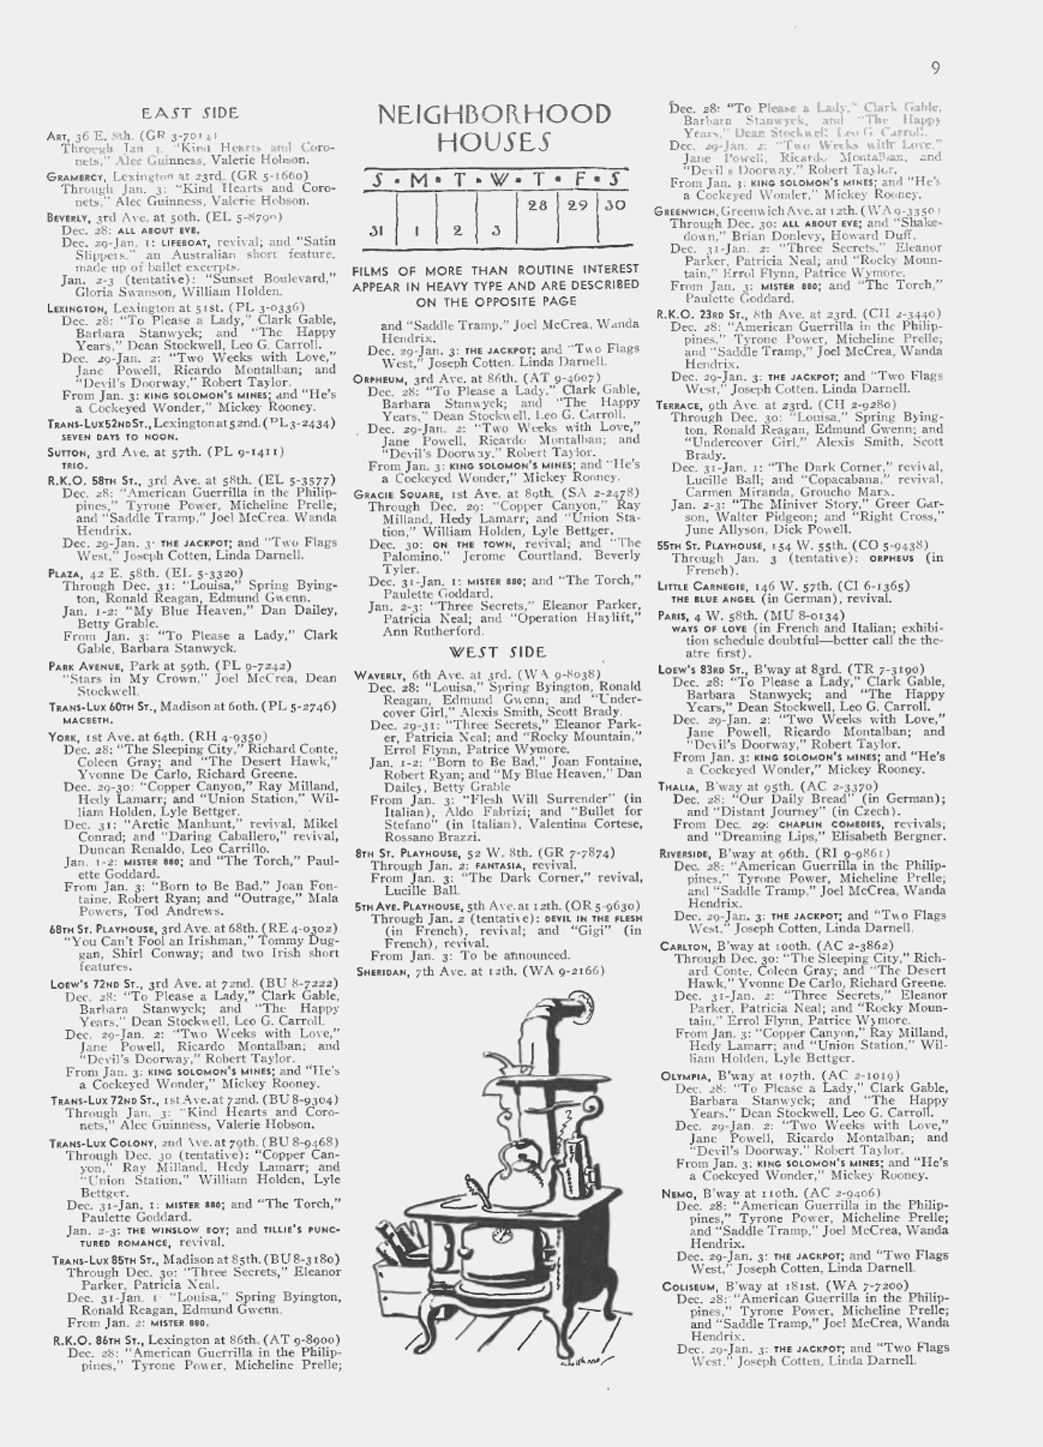

In [ ]:
# Split the image into two parts if there are two sections

def binerize(im):
  """ Convert color image to black and white binary """
  img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
  img_binary = cv2.threshold(np.array(img_gray), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # OTSU binarization
  return img_binary


def split_image(im, do_split):
  """ # Split the image in two, if it has a " . . . " break separating the TITLE->THEATER and THEATER->TITLE sections """

  im = np.asarray(im)

  # Only split New Yorker, not Jerusalem Post
  if not do_split:
    return im, None

  # Binerize
  binary_img = binerize(im)
  binary_img_inverse = 255-binary_img

  # Use kernel to detect individual black dots with plenty of white space all the way around each one
  circle_size = round(res_y/416) # Dividing 833 so that the original resolution 1666/416~4
  circle_padding = circle_size * 4
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size)) 
  kernel = np.pad(kernel, circle_padding)
  kernel_inverse = 1 - kernel # swap 0's and 1's in kernel
  convolution = cv2.filter2D(binary_img_inverse, -1, kernel_inverse, borderType=cv2.BORDER_CONSTANT)

  # Trim the top and bottom 10% off of the image, since we know there are plenty of matches along those edges that we do not want
  trim = int(res_y / 10)
  convolution_trimmed = convolution[trim:res_y-trim][:]

  # Find the row with the greatest number of matches
  row_matches_count = np.sum(convolution_trimmed, axis=1)
  split_y_trimmed = np.argmin(row_matches_count)
  split_val = row_matches_count[split_y_trimmed]
  split_y = split_y_trimmed + trim

  # Rows with matches have "0" values, so we want the lowest sum. 
  # If we don't meet the threshold, keep the image intact without splitting.
  thresh = res_y * 255 / 3   # if more than 2/3 of the row is a match
  if split_val > thresh:
    return im, None

  # Split the image in two
  split_y = int(split_y)
  img1 = np.copy(im)
  img1 = im[0:split_y][:]
  img2 = im[split_y:][:]
  return img1, img2


img1 = None
img2 = None
if debug:
  img1, img2 = split_image(img_filtered, is_New_Yorker)

Image.fromarray(img1)

In [ ]:
# Get data from image

def img2data(im):
  data = pytesseract.image_to_data(im, output_type=Output.DICT)
  text = str(pytesseract.image_to_string(im))
  return data, text

data1 = None
data2 = None
text1 = ""
text2 = ""
if debug:
  data1, text1 = img2data(img1)
  if img2 is not None:
    data2, text2 = img2data(img2)
  print(text1 + text2)

In [ ]:
# Visualize boxes. Green if confidence is >50%, red if confidence is <=50%

levels = {"page":1, "block":2, "paragraph":3, "line":4, "word":5}

def get_approx_block_width(box_widths):
  box_widths.sort()
  box_widths = np.array(box_widths)

  # We expect blocks to be a around 1/3 the size of the page
  # Remove box_widths that are larger than 1/2 the page
  box_widths = box_widths[box_widths < res_x*0.5]

  # Remove box_widths that are smaller than 1/4 the page
  box_widths = box_widths[box_widths > res_x*0.25]

  if len(box_widths) == 0:
    return None
  return int(np.median(box_widths))

def visualize_boxes(vis_level, im, data):

  n_all_boxes = len(data['text'])

  im = np.asarray(im)
  if len(im.shape) == 3:
    boxes = np.array(im)
  elif len(im.shape) == 2:
    boxes = np.zeros_like(im)
    boxes[:,:,0] = im
    boxes[:,:,1] = im
    boxes[:,:,2] = im
  else:
    print("ERROR: Unexpected image size when visualizing boxes: " + str(im.shape))

  word_counter = 0
  confidence_counter = 0
  box_widths = [] # Keep track of box width so we can keep track of the size of a standard block. This doesn't matter for words.
  for i in range(n_all_boxes):
      if data['level'][i] == levels[vis_level]:
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        if int(data['conf'][i]) > 50:
            boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)
            box_widths.append(w)
            confidence_counter += 1
        elif int(data['conf'][i]) <= 50:
            boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (255, 0, 0), 1)
            box_widths.append(w)
        word_counter += 1

  block_width = get_approx_block_width(box_widths)

  print("Percentage of confident results: " + str(confidence_counter / word_counter))
  return boxes, block_width

block_boxes1, block_width1 = visualize_boxes("block", img1, data1)
block_width2 = None
if img2 is not None:
  block_boxes2, block_width2 = visualize_boxes("block", img2, data2)
if block_width1 is not None:
  block_width = block_width1
else:
  block_width = block_width2

Image.fromarray(block_boxes1)

Percentage of confident results: 0.8323216995447648


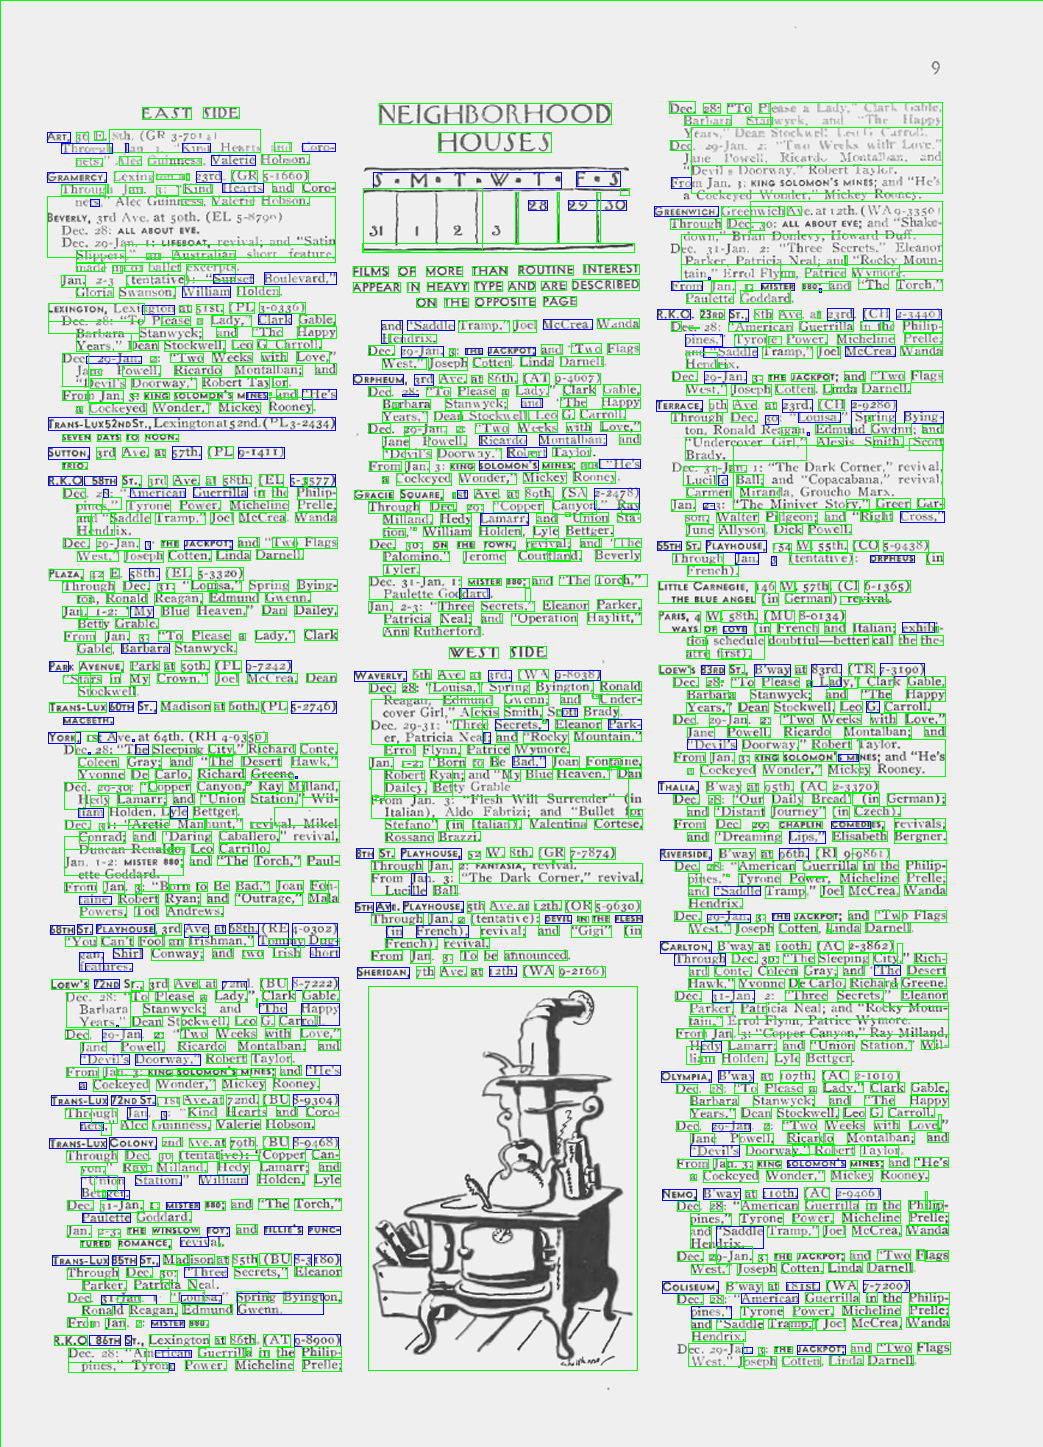

In [ ]:
word_boxes = None
if debug:
  word_boxes, _ = visualize_boxes("word", img1, data1)

Image.fromarray(word_boxes)

In [ ]:
# Read all the text in the page into one string

def replace_characters(line):
  """Fix commonly mis-detected characters"""

  # Standardize characters like " and -
  transl_table = dict( [ (ord(x), ord(y)) for x,y in zip( u"‘’´“”–-—",  u"'''\"\"---") ] )

  line = line.translate( transl_table )
  line = line.replace("''", "\"")
  line = line.replace("``", "\"")
  line = line.replace("Sun,", "Sun.")
  line = line.replace("Mon,", "Mon.")
  line = line.replace("Tues,", "Tues.")
  line = line.replace("Wed,", "Wed.")
  line = line.replace("Thurs,", "Thurs.")
  line = line.replace("Fri,", "Fri.")
  line = line.replace("Sat,", "Sat.")
  return line

def clean_text(text, data, indent_thresh=10):
  """ 
  Go through the newspaper data word-by-word and clean the text.
  text = the string form of the OCR
  data = the data form of the OCR, which includes word/block start positions
  indent_thresh = the number of pixels of indent between the start of a listing, and continuation of that text in the next line of the paragraph
  """
  
  txt = ""
  curr_block_left_pos = None
  prev_block_left_pos = None
  for i in range(len(data['text'])):
    word          = data['text'][i]
    confidence    = data['conf'][i]
    level_num     = data['level'][i]
    block_num     = data['block_num'][i]
    paragraph_num = data['par_num'][i]
    line_num      = data['line_num'][i]
    word_num      = data['word_num'][i]
    box          = (data['left'][i], data['top'][i], data['width'][i], data['height'][i]) # (x, y, w, h) 
    
    word = replace_characters(word)

    # See how the left-position of the word compares to the left-position of the block. 
    # If they are the same (or close), consider that to be the start of the listing.
    if level_num == levels["block"]:
      # Save the previous block position, to use for comparison
      if curr_block_left_pos:
        prev_block_left_pos = curr_block_left_pos

      # Get the current block position
      curr_block_left_pos = box[0]
      curr_block_width = box[2]


    # Put the words together into paragraphs
    if level_num == levels["word"]:
      curr_word_left_pos = box[0]

      # It's the start of a listing if: 
      #     - the word is within a threshold (e.g. 15 pixels) of the left start position of the block
      #     - the curr_block_width is within a threshold of the identified typical block_width (basically, ignore tiny, word-sized false "blocks")
      if len(word) > 1 and block_width is not None and \
        abs(curr_word_left_pos - curr_block_left_pos) <= indent_thresh and \
        abs(block_width - curr_block_width) < indent_thresh*2:
        txt = txt + "\n" + word + " "

      # Otherwise, it's a continuation of the current listing. 
      # If the word ends in "-" it's probably broken up across lines, e.g. temp-orary
      #elif len(word) > 0 and word[-1] == "-":
      #  txt = txt + word[:-1]

      # If it's just a regular word
      elif len(word) > 0: 
        txt = txt + word + " "

  return txt

cleaned_text1 = ""
cleaned_text2 = ""

if debug:
  indent_thresh = math.floor(img_filtered.size[0]/150.)
  print(indent_thresh)
  cleaned_text1 = clean_text(text1, data1, indent_thresh)
  if img2 is not None:
    cleaned_text2 = clean_text(text2, data2, indent_thresh)

print(cleaned_text1 + cleaned_text2)

6
EAST SIDE         Any, 36 E. 'Throws J: Kirt aril Coro nets," Alee Guinness, Valerie Holmon. Gramercy, Lexington at 23rd. (GR 5-1660) 'Through Jan, 'Kind Hearts and Coro-          , ness, Valerie Hobson.        Slippers." an Australian made up of ballet Jan, 2-3 (tentative): "Sunset Boulevard," Gloria Swanson, Willian Holden. jugion at 518t. (PL 3-0336) ease 2 Lady," Clark Gable, Stanwyek; and" "The Happy Dean Stockwell, Leo G. Carroll.  29-Jan. 2: "Two Weeks with Love,' ne Powell, Ricardo Montalban; and Devil's Doorway," lor. From Jan. 3: XING SOLOMON's mines; and "He's a Cackeyed Wonder," Mickey Rooney. Trans-Lux52noSr,,Lexingtonatsand.(PL3-2434) SEVEN DATS TO NOON. Surrox, 3rd Ave, at 57th. (PL 9-1411) 1810. R.K.O. S8rn Sr., grt! Ave, at sith. (EL 5-357)                              
Dec, #8; "American Guerfilla in the Philip- pines," Tyrone Power, Micheline Prelle, and "Saddle Tramp," Joe! MeCrea, Wanda Dee. 29-Jan, 5° me sackror; and "Two Flags West," Joseph Cotten, Linda Darnel

In [ ]:
# Remove headers at the tops of columns, which may split a listing in two

def remove_headers(txt):

  header_lines = [
                  "MOTION PICTURES",
                  "THE MOVIE HOUSES",
                  "FILMS OF MORE THAN ROUTINE INTEREST",
                  "ARE DESCRIBED IN THIS SECTION AND",
                  "APPEAR IN HEAVY TYPE IN THE PROGRAM",
                  "ARE DESCRIBED IN THIS SECTION AND APPEAR IN HEAVY TYPE IN THE PROGRAM",
                  "ARE DESCRIBED IN THIS SECTION AND AP-",
                  "PEAR IN HEAVY TYPE IN THE PROGRAM",
                  "THE BROADWAY AREA",
                  "APPEAR IN HEAVY TYPE AND ARE DESCRIBED",
                  "FILMS OF INTEREST APPEAR IN HEAVY TYPE AND ARE DESCRIBED ABOVE"

  ]

  header_lines_ending = [
                  "ARE DESCRIBED IN THIS SECTION", 
                  "SCHEDULES THAT FOLLOW", 
                  "IN THE SECTION ABOVE", 
                  "ON THE OPPOSITE PAGE" 
  ]

  txt_without_headers = txt
  
  for txt_line in txt.split("\n"):
    for header_line in header_lines:

      # Strip and lower the txt_line for testing
      test_line = txt_line.upper().strip()
      if test_line.endswith(".") or test_line.endswith(","):
        test_line = test_line[:-1]


      # If there is an exact match, remove
      if header_line in test_line:
          print("Removing line '" + txt_line + "'")
          txt_without_headers = txt_without_headers.replace(txt_line+"\n", "")

      # Otherwise, look for a fuzzy match with confidence > 0.9
      else:
        # Check levenshtein distance 
        distance = lev.distance(test_line.upper(), header_line)
        ratio = lev.ratio(test_line, header_line)
        if ratio > 0.9:
          print("Removing line '" + txt_line + "' with confidence " + str(ratio))
          txt_without_headers = txt_without_headers.replace(txt_line+"\n", "")


  return txt_without_headers

flowing_text1 = ""
flowing_text2 = ""
if debug:
  flowing_text1 = remove_headers(cleaned_text1)
  if img2 is not None:
    flowing_text2 = remove_headers(cleaned_text2)

print(flowing_text1 + flowing_text2)

Removing line '             FILMS OF MORE THAN ROUTINE INTEREST APPEAR IN HEAVY TYPE AND ARE DESCRIBED 'ON THE OPPOSITE PAGE gra "Saddle Tramp." Joel McCrea, Wanda Hendrix. Dec, 29-Jai. 3: 1me sacnror; and "Two Flags 'Joseph Cotten. Linda Darnell Onneum, grd Ave. at 86th. (AT 9-3607) Dec. 2X: "To Please a Lady." Clark Gable, Barbara Stanwyck; and" "The Happy Years," Dean Stockwell. Leo G. Carroll. Dec. 29-Jan, 2: "Two Weeks with Love," 'Jane Powell, Ricardo Montalban; and "Devil's Doorway." Rotert Taylor. From Jan, 3: KING Solomon's wines: and "Tle's 'a Cackeyed Wonder," Mickey Rooney Gracie Souane, ist Ave. at Sotk (SA 22478) "Through Dee. 29; "Copper Canyon," Ray Milland, Hedy Lamars and "Union Sta-                            tion," William Holden,' Lyle Bettger. '
Removing line '             FILMS OF MORE THAN ROUTINE INTEREST APPEAR IN HEAVY TYPE AND ARE DESCRIBED 'ON THE OPPOSITE PAGE gra "Saddle Tramp." Joel McCrea, Wanda Hendrix. Dec, 29-Jai. 3: 1me sacnror; and "Two Flags 'Jose

In [ ]:
# Helper functions for New Yorker

def stripLastComma(line):
    # Strip the last character from a line of text, if it is a comma
    if len(line) == 0:
        return None
    elif line[-1] == ',':
        return line[:-1]
    else:
        return line

def stripFirstQuote(line):
    # Strip the first character from a line of text, if it is a "
    if len(line) > 0 and line[0] == '"':
        return line[1:]
    else:
        return line

def checkPotentialTitle(line, startIndex, existingTitles):
    potentialTitle = line[startIndex+1:].split(",")[0].strip()
    potentialTitle = stripFirstQuote(potentialTitle)
    # If any of the following words are in the text, it's probably not a title
    #TODO "through" and "from"
    if not any(txt in potentialTitle.lower() for txt in ["revival", "sun.", "mon.", "tues.", "wed.", "thurs.", "fri.", "sat.", "sun."]):
        # If this is not one of the titles already, and does not have quotes, since we already got those
        if not any(txt and (txt in potentialTitle) for txt in existingTitles):
            return potentialTitle.strip()
    return

def find_titles_in_quotes(line, quoteIndices):
    titles = []
    # If there are two "s, we are good to go
    if len(quoteIndices) == 2:
        title = line[quoteIndices[0]+1:quoteIndices[1]]
        titles.append(stripLastComma(title))

    # If there are an even number of "s, return the list of titles
    elif len(quoteIndices) % 2 == 0:
        titles = []
        for i in range(0, len(quoteIndices), 2):
            title = line[quoteIndices[i]+1:quoteIndices[i+1]]
            titles.append(stripLastComma(title))
        return titles
    
        # If there is an odd number of "s
    else:
        pass
    
    return titles
    
def find_titles(line):
    titles = []
    # Search for the movie title. There are several places it can be.
    # The easiest is if it is in quotes.
    
    # Fix common issues with quotes
    line = line.replace(",'", ",\"")
    line = line.replace(": '", ": \"")
    line = line.replace("-'", "-\"")
    line = line.replace(" '", "\"")
    line = line.replace("\"\"", "\"")
    line = line.replace("\"'", "\"")
    line = line.replace("'\"", "\"")
    
    # Find title if it is in between quotes (e.g. "Title")
    quoteIndices = [i for i, ltr in enumerate(line) if ltr == '"']
    titles = find_titles_in_quotes(line, quoteIndices)
        
    # If nothing was returned, there is likely an odd number of quotes. Fix and try again.
    if len(titles)==0:
        newQuoteIndices = [i for i, ltr in enumerate(line) if ltr == '"']
        titles = find_titles_in_quotes(line, newQuoteIndices)
    
    # Find title if it is NOT in between quotes. This is harder.
    # Title usually comes after : or after - and before , but not "revivals" or "through" or "from"
    colonIndices = [i for i, ltr in enumerate(line) if ltr == ':']
    dashIndices =  [i for i, ltr in enumerate(line) if ltr == '-']
    
    for colonIndex in colonIndices:
        potentialTitle = checkPotentialTitle(line, colonIndex, titles)
        if potentialTitle:
            titles.append(potentialTitle)
    
    for dashIndex in dashIndices:
        potentialTitle = checkPotentialTitle(line, dashIndex, titles)
        if potentialTitle:
            titles.append(potentialTitle)
       
    # Finally, check if title is the first thing in this line (e.g. directly after "; also")
    potentialTitle = checkPotentialTitle(line, 0, titles)
    if potentialTitle:
        titles.append(potentialTitle)

    return titles


def fuzzy_match_theater_names(text, theaters):
  best_ratio = 0
  best_match = None

  for theater in theaters:
    distance = lev.distance(text.lower(),theater.lower()),
    ratio = lev.ratio(text.lower(),theater.lower())
    if ratio > best_ratio:
      best_ratio = ratio
      best_match = theater

  return best_match, best_ratio


def is_listing(line):
  """Check if this line of text is a listing, or something else (i.e. header)"""

  # If there is a period, or multiple commas, that's a good indicator it's not a header
  if line.count(",") > 1 or line.count(".") > 0:
    return True

  # If there are parens (), it's probably a listing
  if "(" in line and ")" in line:
    return True

  # If the first word is a theater name with high confidence, it's almost definitely a listing
  theater, fuzzy_theater, confidence = get_theater_if_first(line)
  if confidence > 0.6:
    return True

  return False


  
def get_theater_if_first(line):
    """Checks if the theater is the first thing in this listing. If it isn't , assume that the movie title is the first thing in this listing."""
    segments_comma = line.split(',')

    # Read names of theaters into list
    theater_names_file = open("./newspapers/NewYorker/NYC-Theaters-copied-from-New-Yorker.txt", "r")
    theater_names = theater_names_file.read().split('\n')
    theater_names_file.close()

    raw_theater = segments_comma[0].strip()
    fuzzy_theater, fuzzy_confidence = fuzzy_match_theater_names(raw_theater, theater_names)

    return raw_theater, fuzzy_theater, fuzzy_confidence


def find_theaters_in_text(line):
  start_index = 0
  end_index = 0
  theater = None

  # Read names of theaters into list
  theater_names_file = open("./newspapers/NewYorker/NYC-Theaters-copied-from-New-Yorker.txt", "r")
  theater_names = theater_names_file.read().split('\n')
  theater_names_file.close()

  matches = []
  for theater_name in theater_names:
    if len(theater_name) > 2:
      if regex.search('('+theater_name+'){e<=2}', line):
        matches.append(theater_name)

  return matches


def extract_year_from_title(text):
  """ If there is a year in the title, separate the title and the year """
  if not text:
    return None, None

  year = re.findall('[1-2][0-9]{3}', text)
  if len(year) == 0:
    year = ""
    title = text
  else:
    year = year[0]  # assumes there is only one year in the title

    # If there is a "(" before the detected numbers, then it's probably a year
    if "(" + year in text:
      title = text[:text.index("(" + year)]

    # Otherwise, it's probably mis-detected text. Return the potential title, but don't extract a year from it.
    else:
      year = ""
      title = text

  return title, year

In [ ]:
def jerusalem_post_text2csv(text, csv_path):
  with open(csv_path, "w", newline='') as csv_file, open(csv_path[:-4]+".log", "w") as log_file:
    writer = csv.writer(csv_file, delimiter=',')

    writer.writerow(["Theater", "Title", "Raw"])

    seen_word_cinemas = False
    for line in text.split('\n'):
      line = line.strip()
      
      # We only care about text after the first line containing the word "cinemas"
      if seen_word_cinemas:

        # We use ":" as the separator between the theater and the film, so we only want lines that contain it.
        if ":" in line:
          sections = line.split(":")
          theater = sections[0]
          potential_title = sections[1]
  
          # potential_title might have additional information like time, etc
          # Ignore everything after punctuation . or , or (
          title = potential_title.split(".")[0] # Remove text after "."
          title = title.split(",")[0]           # Remove text after ","
          title = title.split("(")[0]           # Remove text after "("

          writer.writerow([theater, title, line])

      if "cinemas" in line.lower():
        seen_word_cinemas = True


In [ ]:
# Write CSV and further improve the text

def new_yorker_text2csv(text, csv_path, mode, discard_threshold=0.4, adjust_threshold=0.85, write_header=True):

  with open(csv_path, mode, newline='') as csv_file, open(csv_path[:-4]+".log", mode) as log_file:
      writer = csv.writer(csv_file, delimiter=',')
      
      # Write header if we are starting the document
      if mode=="w":
        writer.writerow(["Theater", "Location", "Title", "Year", "Raw"])
        
      # Write content
      for line in text.split('\n'):
          line = line.strip()
          
          if is_listing(line):


            # If the format of the line is THEATER FIRST, THEN FILM TITLE(S)
            raw_theater, fuzzy_theater, confidence = get_theater_if_first(line)
            if raw_theater and confidence > discard_threshold:
          
              segments_comma = line.split(',')
              
              # The theater location is always after first "," and before the first "(""
              comma_index = line.find(',')
              openParen_index = line.find('(')
              closeParen_index = line.find(')')
              location = line[comma_index+1:openParen_index].strip()
                  
              # If "; also" or "..." appears, that means there is a list. Split on those (and variations)
              listOfFilms = re.split('\.\.\.|,\.\.|; also|also', line[closeParen_index+1:])
                  
              for filmLine in listOfFilms:
                  titles = find_titles(filmLine) # This may catch additional lists
                  for title in titles:

                      # If there is a year in the title, pull it out
                      title, year = extract_year_from_title(title)
                      if title:
                        writer.writerow([raw_theater, location, title, year, line])


              # If the format of the line is FILM TITLE FIRST, THEN THEATER(S)
            elif len(line) > 0:

              # Film name is always before a dash
              segments_dash = line.split("-")
              if len(segments_dash) > 1:
                index_of_dash = line.index("-")
                title = line[:line.index("-")]

                segments_paren = line.split("(")

                # Split on semicolon
                segments_semicolon = segments_paren[-1].split(";")
                num_segments_semicolon = len(segments_semicolon)

                # Semicolons separate theaters. If there isn't a semicolon, there's only one theater.
                for i in range(num_segments_semicolon):
                  fragment = segments_semicolon[i]
                  segments_comma = fragment.split(",")


                  if len(segments_comma) > 1:
                    theater_segment = segments_comma[0]

                    # There may be a list of theaters, not just one. If so, theaters are split by one or more of the following:
                    # "@" or "..." or "and"
                    if "@" in theater_segment:
                      theater = theater_segment.split("@")[1]
                    elif "..." in theater_segment:
                      if "...." in theater_segment: # there may be 3 or 4 (... or ....)
                        theater = theater_segment.split("....")[1]
                      else:
                        theater = theater_segment.split("...")[1]
                    else:
                      theater = theater_segment

                    theater = theater.strip()

                    # Remove "and" from the start of a line in case it is there
                    if theater.startswith("and"):
                      theater = theater[4:]

                    # If there is a year in the title, pull it out
                    title, year = extract_year_from_title(title)

                    # If the text is very long, chances are it isn't actually a theater name
                    if len(theater.split(" ")) < 6:

                      location = segments_comma[1]
                      if title:
                        writer.writerow([theater, location, title, year, line])

                    else:
                      # Theater name not detected
                      log_text = "Theater name expected but not found in text '" + theater + "'. Full line is: " + line
                      print("WARNING: " + log_text)
                      log_file.write(log_text + "\n\n")

              else:
                # Film title not detected
                log_text = "Film title expected but not found in line: " + line
                print("WARNING: " + log_text)
                log_file.write(log_text + "\n\n")

df = None
if debug:
  csv_path = path[:-4]+".csv"
  if is_New_Yorker:
    new_yorker_text2csv(flowing_text1, csv_path, "w")
    if cleaned_text2 is not None:
      new_yorker_text2csv(flowing_text2, csv_path, "a")
  else:
    jerusalem_post_text2csv(flowing_text1, csv_path)
  df = pd.read_csv(csv_path)

df.head(50)

In [ ]:
# Loop through and process all files in a year
if not debug:
  path = "./newspapers/NewYorker/1950/"
  for filename in os.listdir(path):
    print(filename)
    img, is_New_Yorker = load_page(path + filename)
    img_filtered = filter(img)
    img1, img2 = split_image(img_filtered, is_New_Yorker)
    data1, text1 = img2data(img_filtered)
    cleaned_text1 = clean_text(text1, data1)


    # If we are reading New Yorker
    if is_New_Yorker:
      flowing_text1 = remove_headers(cleaned_text1)
      new_yorker_text2csv(flowing_text1, path + "csv/" + filename[:-4]+".csv", "w")
    
    # If we are reading Jerusalem Post
    elif is_Jerusalem_Post:
      jerusalem_post_text2csv(cleaned_text1, path + "csv/" + filename[:-4]+".csv", "w")

    else:
      print("ERROR: Unsupported extension of " + filename + ". Must be PNG (New Yorker) or PDF (Jerusalem Post).")
      sys.exit()

    # Only New Yorker gets split into two, so no need to separate in this case
    if img2 is not None:
      data2, text2 = img2data(img_filtered)
      cleaned_text2 = clean_text(text2, data2)
      flowing_text2 = remove_headers(cleaned_text2)
      new_yorker_text2csv(flowing_text2, path + "csv/" + filename[:-4] +".csv", "a") # append to existing file

    cv2_imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))